# 결함 검출 및 분류 파이프라인

이 노트북은 학습 완료된 U-Net 모델을 사용하여 data 폴더의 이미지들에서 결함을 검출하고, CNN 모델로 결함 유형을 분류합니다.

## 진행 순서
1. **U-Net 단계**: 모든 이미지에서 결함 검출
2. **U-Net 결과 분석**: 검출 결과 시각화 및 통계
3. **CNN 단계**: 결함이 발견된 이미지들에 대해 결함 유형 분류
4. **최종 결과 분석**: 분류 결과 통계 및 시각화


In [ ]:
# GPU 확인
import tensorflow as tf

device_name = tf.test.gpu_device_name()
print('GPU not found.') if device_name != '/device:GPU:0' else print('Found GPU at: {}'.format(device_name))


In [1]:
# 필요한 라이브러리 import
import tensorflow as tf
from utils.cnn.defect_detection import scan_data_directory
from utils.cnn.pipeline import (
    detect_defects_batch,
    analyze_unet_results,
    visualize_unet_results,
    visualize_defect_samples,
    load_cnn_model_safe,
    classify_defects_with_cnn,
    analyze_final_results,
    analyze_defect_by_type
)

In [2]:
# 경로 설정
data_dir = 'data'  # data 폴더 경로
unet_model_path = 'saved_models/FL_2_5_32_8e05_HoldoutPart06_1.h5'  # 학습된 U-Net 모델 경로
cnn_model_path = 'none'  # 학습된 CNN 모델 경로 (없으면 None)

print(f"Data 디렉터리: {data_dir}")
print(f"U-Net 모델 경로: {unet_model_path}")
print(f"CNN 모델 경로: {cnn_model_path}")


Data 디렉터리: data
U-Net 모델 경로: saved_models/FL_2_5_32_8e05_HoldoutPart06_1.h5
CNN 모델 경로: none


In [3]:
## 1단계: U-Net 모델 로드 및 결함 검출

# 데이터 개수 제한 설정 (None이면 전체 사용)
max_files = 100  # 예: 100으로 설정하면 처음 100개 파일만 사용

# data 디렉터리 스캔 및 파일 그룹 생성
print("data 디렉터리 스캔 중...")
try:
    file_list = scan_data_directory(data_dir)
    print(f"총 {len(file_list)}개의 파일 발견")
    
    # 데이터 개수 제한 적용
    if max_files is not None and max_files > 0:
        file_list = file_list[:max_files]
        print(f"데이터 개수 제한: {len(file_list)}개 파일 사용")
    
    # 모든 파일을 하나의 그룹으로 묶기 (검출용)
    file_groups = {'dataset': file_list}
    print(f"데이터셋 그룹 구성: {len(file_groups)}개 그룹")
    
except Exception as e:
    print(f"오류 발생: {e}")
    file_list = []
    file_groups = {}

# 데이터셋 생성 (dict 구조)
from utils.u_net.dataset_functions import create_dataset

imagePath0 = f'{data_dir}/0/'
imagePath1 = f'{data_dir}/1/'
npyPath = f'{data_dir}/annotations/'
tileSize = 128

print("\n데이터셋 생성 중...")
datasetImageDict, datasetMaskDict = create_dataset(
    file_groups, 
    imagePath0, 
    imagePath1, 
    npyPath, 
    tileSize=tileSize
)

# U-Net 모델 로드 (compile=False로 로드)
print("\nU-Net 모델 로드 중...")
fl_model = tf.keras.models.load_model(unet_model_path, compile=False)
print("U-Net 모델 로드 완료!")
print(f"모델 입력 shape: {fl_model.input_shape}")
print(f"모델 출력 shape: {fl_model.output_shape}")

data 디렉터리 스캔 중...
총 693개의 파일 발견
데이터 개수 제한: 100개 파일 사용
데이터셋 그룹 구성: 1개 그룹

데이터셋 생성 중...

dataset...
  처리 중: 50/100 파일 완료 (현재 타일 수: 1250)
  처리 중: 100/100 파일 완료 (현재 타일 수: 2500)
Contains 100 images...
Tiled Image Tensor Shape:  (2500, 128, 128, 2)
Tiled Mask Shape:  (2500, 128, 128)

U-Net 모델 로드 중...
U-Net 모델 로드 완료!
모델 입력 shape: (None, 128, 128, 2)
모델 출력 shape: (None, 128, 128, 3)


In [4]:
# U-Net으로 결함 검출 수행
from utils.u_net.dataset_functions import unwrap_client_data
from utils.u_net.image_processing import unsplit_image_mask
import numpy as np

tileSize = 128
defect_threshold = 0.01

# datasetImageDict에서 이미지 가져오기
dataset_keys = ['dataset']
testImages, testMasks = unwrap_client_data(datasetImageDict, datasetMaskDict, dataset_keys)

# 모델로 예측 수행
print("\n" + "="*60)
print("1단계: U-Net 결함 검출 시작")
print("="*60)
print(f"총 {testImages.shape[0]}개 타일 예측 중...")

predictedImages = fl_model.predict(testImages, verbose=0)
predictedMask = tf.argmax(predictedImages, axis=-1)

# 각 이미지별로 타일을 재구성하고 결함 검출
unet_results = []
curr_idx = 0

for file_name in file_list:
    # 각 이미지는 640x640 = 5*5 = 25 타일 (data 폴더 기준)
    num_tiles_per_image = 25
    prev_idx = curr_idx
    curr_idx = prev_idx + num_tiles_per_image
    
    # 타일들을 원본 이미지 크기로 재구성
    imageheight, imagewidth = 5*128, 5*128  # 640x640
    fullPredictedMask = unsplit_image_mask(
        predictedMask[prev_idx:curr_idx], 
        imageheight, 
        imagewidth
    )
    
    # 결함 픽셀 비율 계산 (클래스 2가 결함)
    defect_mask = fullPredictedMask[0, :, :, 0].numpy()
    defect_ratio = np.sum(defect_mask == 2) / defect_mask.size if defect_mask.size > 0 else 0.0
    has_defect = defect_ratio > defect_threshold
    
    unet_results.append({
        'file_name': file_name,
        'has_defect': has_defect,
        'defect_ratio': defect_ratio,
        'mask': defect_mask  # 나중에 시각화를 위해 저장
    })

defect_count = sum(1 for r in unet_results if r['has_defect'])
print(f"\nU-Net 검출 완료! 총 {defect_count}개의 결함 이미지 발견")


1단계: U-Net 결함 검출 시작
총 2500개 타일 예측 중...

U-Net 검출 완료! 총 100개의 결함 이미지 발견


In [5]:
## 2단계: U-Net 검출 결과 분석

# U-Net 검출 결과 분석
df_unet = analyze_unet_results(unet_results, output_file='unet_detection_results.csv')



U-Net 검출 결과 요약
총 파일 수: 100
결함 발견: 100개
결함 없음: 0개

결함 픽셀 비율 통계:
  평균: 0.208148
  최소: 0.113975
  최대: 0.507817
  중앙값: 0.167031

U-Net 검출 결과가 unet_detection_results.csv에 저장되었습니다.

U-Net 검출 결과 미리보기 (상위 20개)
   file_name  has_defect  defect_ratio
0     000001        True      0.306785
1     000002        True      0.332205
2     000003        True      0.507817
3     000004        True      0.455769
4     000005        True      0.507817
5     000006        True      0.455769
6     000007        True      0.306809
7     000008        True      0.332205
8     000009        True      0.334248
9     000010        True      0.504075
10    000011        True      0.456311
11    000012        True      0.312771
12    000013        True      0.456311
13    000014        True      0.312771
14    000015        True      0.334248
15    000016        True      0.504075
16    000017        True      0.113975
17    000018        True      0.157852
18    000019        True      0.231804
19    000020     

d:\iot\IoT_FL_AM\utils\cnn\pipeline.py:218: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\iot\IoT_FL_AM\utils\cnn\pipeline.py:218: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\iot\IoT_FL_AM\utils\cnn\pipeline.py:218: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\iot\IoT_FL_AM\utils\cnn\pipeline.py:218: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\iot\IoT_FL_AM\venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\iot\IoT_FL_AM\venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io,

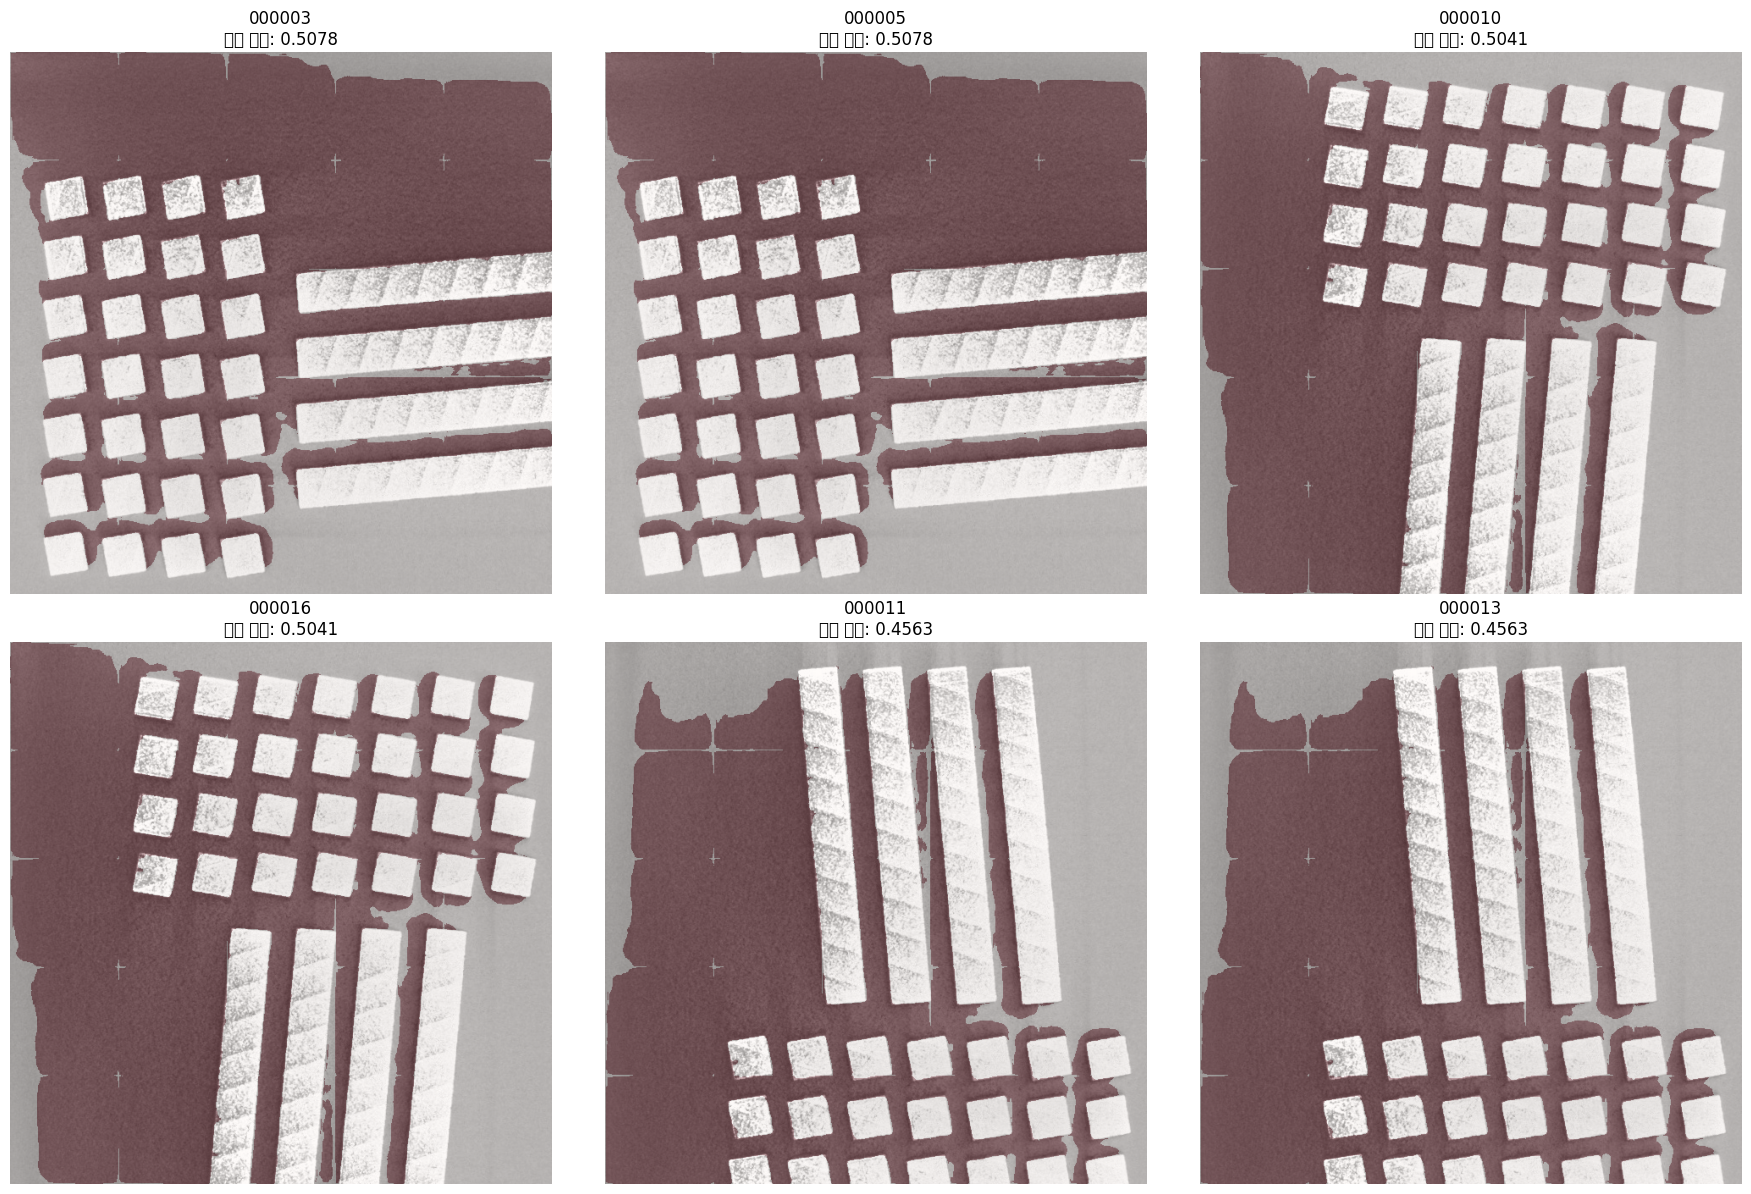

In [6]:
# 결함이 발견된 이미지 샘플 시각화 (선택사항)
visualize_defect_samples(unet_results, data_dir, num_samples=6)


In [7]:
## 3단계: CNN 모델 로드 및 결함 유형 분류

# CNN 모델 로드
cnn_model, label_mapping = load_cnn_model_safe(cnn_model_path)


PyTorch device: cuda
경고: CNN 모델이 없습니다. 먼저 CNN 모델을 학습해야 합니다.
결함 검출만 수행합니다.


In [8]:
# CNN으로 결함 유형 분류 (결함이 발견된 이미지들만)
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_size = (640, 640)

final_results = classify_defects_with_cnn(
    cnn_model=cnn_model,
    unet_results=unet_results,
    data_dir=data_dir,
    device=device,
    target_size=target_size,
    label_mapping=label_mapping
)



CNN 모델이 없어서 분류를 수행하지 않습니다.


## 4단계: 최종 결과 분석


In [9]:
# 최종 결과 분석 및 요약
df_results = analyze_final_results(
    final_results=final_results,
    cnn_model=cnn_model,
    output_file='defect_classification_results.csv'
)



최종 결과 요약
총 파일 수: 100
결함 발견: 100개
결함 없음: 0개

최종 결과가 defect_classification_results.csv에 저장되었습니다.

최종 결과 미리보기 (상위 20개)
   file_name  has_defect  defect_ratio defect_type defect_type_label confidence
0     000001        True      0.306785        None              None       None
1     000002        True      0.332205        None              None       None
2     000003        True      0.507817        None              None       None
3     000004        True      0.455769        None              None       None
4     000005        True      0.507817        None              None       None
5     000006        True      0.455769        None              None       None
6     000007        True      0.306809        None              None       None
7     000008        True      0.332205        None              None       None
8     000009        True      0.334248        None              None       None
9     000010        True      0.504075        None              None       None
10 

In [10]:
# 결함 유형별 상세 분석
analyze_defect_by_type(final_results, cnn_model)



결함이 발견되고 분류된 이미지가 없습니다.
